In [1]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import copy
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
from ptflops import get_model_complexity_info

In [3]:
learning_rate =1e-4
BATCH_SIZE = 32
epoch = 100
model_name = "EfficientNet_b3"

In [4]:
path = r"/kaggle/working/" + f"result_{model_name}"
if not os.path.exists(path):
    os.mkdir(path)

In [5]:
train_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/train"
val_path = r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/val"
test_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/test"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transform = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))  
    ]),
    "Validation": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform["Train"])
val_dataset = datasets.ImageFolder(root=val_path, transform=data_transform["Validation"])
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform["Test"])

print("Classes:", train_dataset.classes)

print(f"Số lượng ảnh trong tập train: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập val: {len(val_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")

Classes: ['Leaf_Algal', 'Leaf_Blight', 'Leaf_Colletotrichum', 'Leaf_Healthy', 'Leaf_Phomopsis', 'Leaf_Rhizoctonia']
Số lượng ảnh trong tập train: 1814
Số lượng ảnh trong tập val: 387
Số lượng ảnh trong tập test: 394


In [6]:
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= True)

data_loader= {"Train": train_loader,
                "Validation": val_loader}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

num_features =model.classifier[1].in_features
model.classifier[1]= nn.Linear(num_features, 6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 173MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [9]:
def train_model(data_loader, model, criterion, optimizer, num_epochs, device, early_stop= True, patience=10):
    model= model.to(device)
    model= torch.nn.DataParallel(model)

    since =time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc =0.0
    best_epoch = 0.0
    wait = 0

    history = {"Train_Loss":[],"Train_Acc":[],"Validation_Loss":[],"Validation_Acc":[],"Time":[]}

    result_current = {"Train_Loss": None,
                        "Train_Acc":None,
                        "Validition_Loss": None,
                        "Validition_ACC":None
                     }
    for epoch in range(num_epochs):
        
        print("-----------------------------------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        for phase in ["Train", "Validation"]:
            if phase == "Train":
                model.train()
            else:
                model.eval()

            running_loss, running_correct = 0.0, 0
            total_samples = 0
            
            for images, labels in tqdm(data_loader[phase], desc="Training And Evaluation"):
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase=="Train"):
                    outputs = model(images)
                    _, predicts = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "Train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicts == labels).item()
                total_samples += images.size(0)
                
            epoch_loss = running_loss / total_samples
            epoch_acc = running_correct / total_samples

            result_current[f"{phase}_Loss"] = epoch_loss
            result_current[f"{phase}_Acc"] = epoch_acc
            
            history[f"{phase}_Loss"].append(epoch_loss)
            history[f"{phase}_Acc"].append(epoch_acc)

            if phase == "Validation":
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    wait = 0
                else:
                    wait += 1
        epoch_duration= time.time()- epoch_start
        history["Time"].append(epoch_duration)
        print(f"Train Loss: {result_current['Train_Loss']:.4f}, Train Acc: {result_current['Train_Acc']:.4f}")
        print(f"Valid Loss: {result_current['Validation_Loss']:.4f}, Valid Acc: {result_current['Validation_Acc']:.4f}")
        print(f"Epoch {epoch+1} finished in {epoch_duration:.2f}s")
    
        if early_stop and wait >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs).")
            break
    
    print("-----------------------------------------------------------------------")
    time_elapse = time.time() - since
    print(f"Training Complete In {time_elapse}s")
    
    model.load_state_dict(best_model_wts)

    return model, pd.DataFrame(history), time_elapse, best_val_acc, best_epoch

In [10]:
model, history, time_elapse, best_val_acc, best_epoch = train_model(data_loader=data_loader, model=model, 
                                                                    criterion=criterion, optimizer=optimizer, 
                                                                    num_epochs=epoch, device=device, 
                                                                    early_stop=True, patience=10)

-----------------------------------------------------------------------
Epoch 1/100


Training And Evaluation: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Train Loss: 1.5952, Train Acc: 0.4361
Valid Loss: 1.1741, Valid Acc: 0.6744
Epoch 1 finished in 612.24s
-----------------------------------------------------------------------
Epoch 2/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


Train Loss: 0.9052, Train Acc: 0.7547
Valid Loss: 0.4965, Valid Acc: 0.8656
Epoch 2 finished in 635.88s
-----------------------------------------------------------------------
Epoch 3/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Train Loss: 0.4249, Train Acc: 0.8809
Valid Loss: 0.2434, Valid Acc: 0.9328
Epoch 3 finished in 645.14s
-----------------------------------------------------------------------
Epoch 4/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.92s/it]


Train Loss: 0.2596, Train Acc: 0.9135
Valid Loss: 0.1889, Valid Acc: 0.9432
Epoch 4 finished in 639.42s
-----------------------------------------------------------------------
Epoch 5/100


Training And Evaluation: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


Train Loss: 0.1761, Train Acc: 0.9498
Valid Loss: 0.1578, Valid Acc: 0.9561
Epoch 5 finished in 644.15s
-----------------------------------------------------------------------
Epoch 6/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Train Loss: 0.1569, Train Acc: 0.9487
Valid Loss: 0.1510, Valid Acc: 0.9535
Epoch 6 finished in 649.41s
-----------------------------------------------------------------------
Epoch 7/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Train Loss: 0.1212, Train Acc: 0.9598
Valid Loss: 0.1543, Valid Acc: 0.9587
Epoch 7 finished in 651.71s
-----------------------------------------------------------------------
Epoch 8/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Train Loss: 0.0976, Train Acc: 0.9691
Valid Loss: 0.1488, Valid Acc: 0.9612
Epoch 8 finished in 635.61s
-----------------------------------------------------------------------
Epoch 9/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Train Loss: 0.0957, Train Acc: 0.9708
Valid Loss: 0.1403, Valid Acc: 0.9612
Epoch 9 finished in 626.56s
-----------------------------------------------------------------------
Epoch 10/100


Training And Evaluation: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]


Train Loss: 0.0725, Train Acc: 0.9802
Valid Loss: 0.1439, Valid Acc: 0.9612
Epoch 10 finished in 637.81s
-----------------------------------------------------------------------
Epoch 11/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Train Loss: 0.0697, Train Acc: 0.9785
Valid Loss: 0.1422, Valid Acc: 0.9612
Epoch 11 finished in 633.55s
-----------------------------------------------------------------------
Epoch 12/100


Training And Evaluation: 100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Train Loss: 0.0632, Train Acc: 0.9796
Valid Loss: 0.1358, Valid Acc: 0.9664
Epoch 12 finished in 630.99s
-----------------------------------------------------------------------
Epoch 13/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Train Loss: 0.0462, Train Acc: 0.9879
Valid Loss: 0.1516, Valid Acc: 0.9612
Epoch 13 finished in 621.52s
-----------------------------------------------------------------------
Epoch 14/100


Training And Evaluation: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it]


Train Loss: 0.0546, Train Acc: 0.9824
Valid Loss: 0.1476, Valid Acc: 0.9638
Epoch 14 finished in 630.52s
-----------------------------------------------------------------------
Epoch 15/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Train Loss: 0.0432, Train Acc: 0.9895
Valid Loss: 0.1542, Valid Acc: 0.9612
Epoch 15 finished in 621.58s
-----------------------------------------------------------------------
Epoch 16/100


Training And Evaluation: 100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


Train Loss: 0.0420, Train Acc: 0.9879
Valid Loss: 0.1340, Valid Acc: 0.9716
Epoch 16 finished in 621.29s
-----------------------------------------------------------------------
Epoch 17/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Train Loss: 0.0341, Train Acc: 0.9884
Valid Loss: 0.1368, Valid Acc: 0.9742
Epoch 17 finished in 632.03s
-----------------------------------------------------------------------
Epoch 18/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Train Loss: 0.0327, Train Acc: 0.9895
Valid Loss: 0.1358, Valid Acc: 0.9742
Epoch 18 finished in 609.41s
-----------------------------------------------------------------------
Epoch 19/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Train Loss: 0.0431, Train Acc: 0.9835
Valid Loss: 0.1499, Valid Acc: 0.9690
Epoch 19 finished in 618.15s
-----------------------------------------------------------------------
Epoch 20/100


Training And Evaluation: 100%|██████████| 13/13 [00:24<00:00,  1.92s/it]


Train Loss: 0.0360, Train Acc: 0.9917
Valid Loss: 0.1501, Valid Acc: 0.9690
Epoch 20 finished in 623.15s
-----------------------------------------------------------------------
Epoch 21/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Train Loss: 0.0363, Train Acc: 0.9890
Valid Loss: 0.1490, Valid Acc: 0.9664
Epoch 21 finished in 630.99s
-----------------------------------------------------------------------
Epoch 22/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Train Loss: 0.0176, Train Acc: 0.9945
Valid Loss: 0.1460, Valid Acc: 0.9612
Epoch 22 finished in 648.72s
-----------------------------------------------------------------------
Epoch 23/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Train Loss: 0.0226, Train Acc: 0.9928
Valid Loss: 0.1494, Valid Acc: 0.9612
Epoch 23 finished in 633.46s
-----------------------------------------------------------------------
Epoch 24/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Train Loss: 0.0197, Train Acc: 0.9945
Valid Loss: 0.1708, Valid Acc: 0.9612
Epoch 24 finished in 635.76s
-----------------------------------------------------------------------
Epoch 25/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Train Loss: 0.0371, Train Acc: 0.9862
Valid Loss: 0.1442, Valid Acc: 0.9690
Epoch 25 finished in 619.48s
-----------------------------------------------------------------------
Epoch 26/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Train Loss: 0.0184, Train Acc: 0.9956
Valid Loss: 0.1481, Valid Acc: 0.9742
Epoch 26 finished in 635.99s
-----------------------------------------------------------------------
Epoch 27/100


Training And Evaluation: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]

Train Loss: 0.0299, Train Acc: 0.9928
Valid Loss: 0.1616, Valid Acc: 0.9561
Epoch 27 finished in 639.96s
Early stopping at epoch 27 (no improvement in 10 epochs).
-----------------------------------------------------------------------
Training Complete In 17064.526247262955s


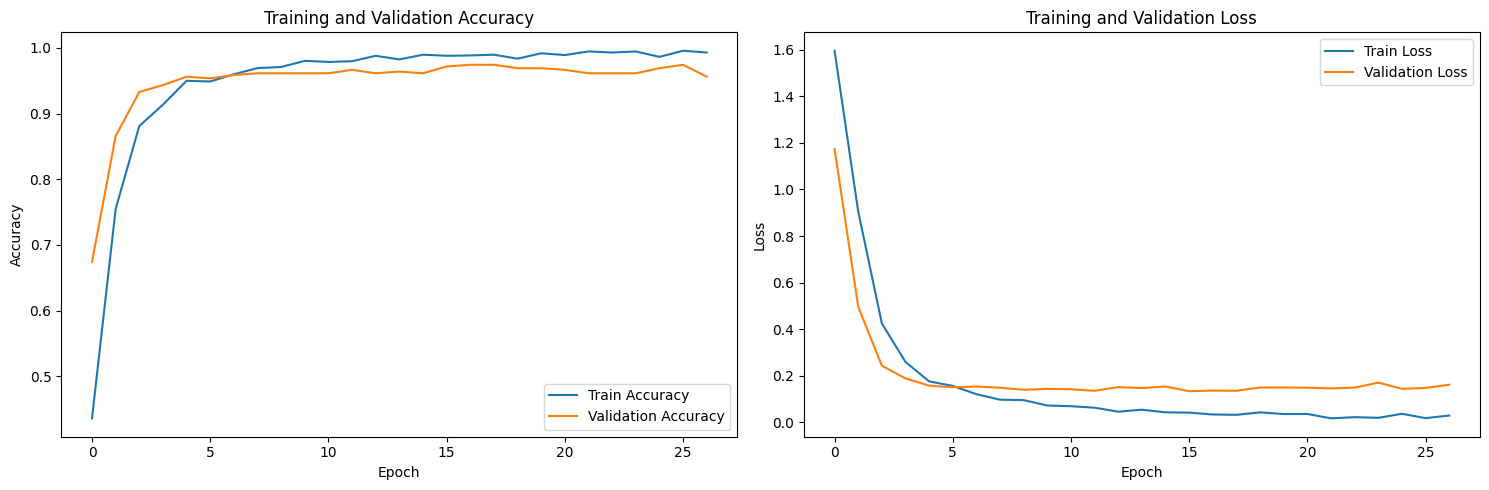

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history['Train_Acc'], label='Train Accuracy')
axs[0].plot(history['Validation_Acc'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history['Train_Loss'], label='Train Loss')
axs[1].plot(history['Validation_Loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(path, "plot_loss_acc.png"))
plt.show()


Accuracy: 0.9390862944162437
Precision: 0.9386251801586297
Recall: 0.9390862944162437
F1-Score: 0.9382329553614707
                     precision    recall  f1-score   support

         Leaf_Algal     1.0000    1.0000    1.0000        70
        Leaf_Blight     0.8889    0.8485    0.8682        66
Leaf_Colletotrichum     0.9091    0.8333    0.8696        60
       Leaf_Healthy     0.9730    0.9730    0.9730        74
     Leaf_Phomopsis     0.9254    0.9841    0.9538        63
   Leaf_Rhizoctonia     0.9231    0.9836    0.9524        61

           accuracy                         0.9391       394
          macro avg     0.9366    0.9371    0.9362       394
       weighted avg     0.9386    0.9391    0.9382       394



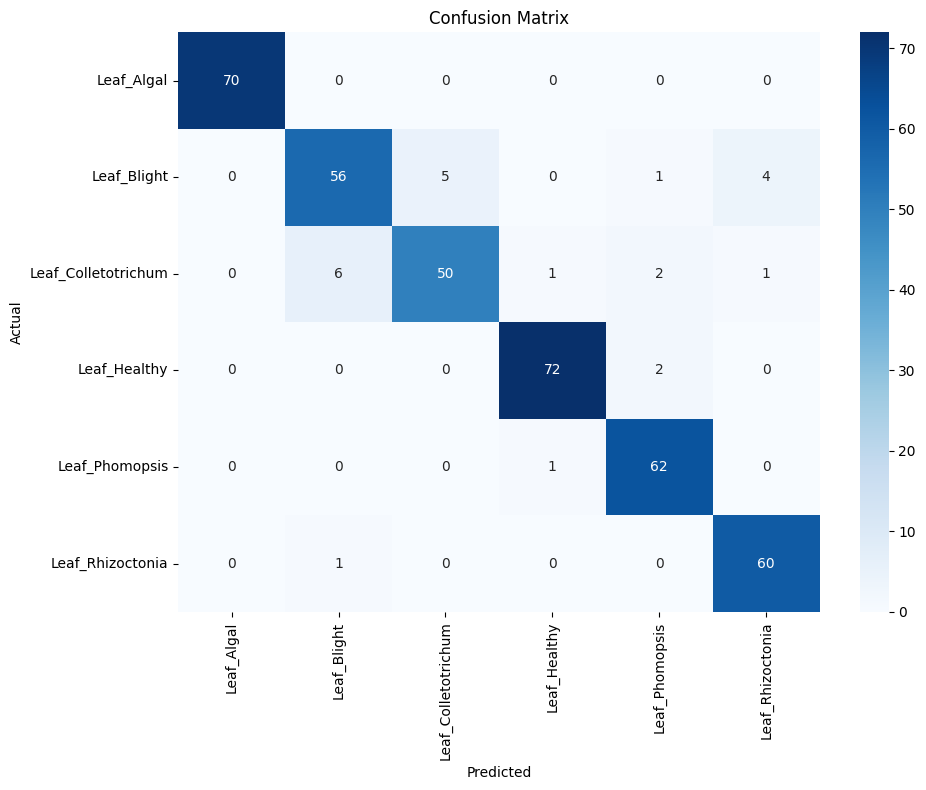

In [12]:
model.eval()

with torch.no_grad():
    
    all_correct = []
    all_predict = []
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicts = torch.max(outputs, dim=1)

        all_correct.extend(labels.cpu().numpy())
        all_predict.extend(predicts.cpu().numpy())

    acc = accuracy_score(all_correct, all_predict)
    precision = precision_score(all_correct, all_predict, average='weighted')
    recall = recall_score(all_correct, all_predict, average='weighted')
    f1 = f1_score(all_correct, all_predict, average='weighted')
    
    input_res = (3, 224, 224)
    flops, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    result = {
        "Model": model_name,
        "Optimizer": "Adam",
        "Learning_Rate": learning_rate,
        "Batch_Size": BATCH_SIZE,
        "Num_Epoch": epoch,
        "Early_Stop": best_epoch,
        "Training_Time": time_elapse,
        "Best_Val_Acc": best_val_acc,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "FLOPs": flops,
        "Params": params,
        "Total_Params": total_params,
        "Trainable_Params": trainable_params,
             }
    
    result_df = pd.DataFrame([result])
    result_df.to_csv(os.path.join(path, "result.csv"), index=False)
    
    report = classification_report(all_correct, all_predict, target_names=train_dataset.classes, digits=4)
    print(report)
    with open(os.path.join(path, "classification_report.txt"), "w") as f:
        f.write(report)
        
    cm = confusion_matrix(all_correct, all_predict)
    
    # Hiển thị confusion matrix dưới dạng heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(os.path.join(path, 'confusion_matrix.png'))
    plt.show()
    
    plt.close()

In [13]:
torch.save(model.state_dict(), os.path.join(path, f'{model_name}_weights.pth'))
history.to_csv(os.path.join(path, "history.csv"), index=False)

In [14]:
import shutil

shutil.make_archive(path, 'zip', path)

'/kaggle/working/result_EfficientNet_b3.zip'